In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [7]:

EPOCHS = 20
BS = 32
imagePaths = list(paths.list_images("C:\\Users\\Admin\\Desktop\\Siddharth\\Deep Learning\\Assesment\\"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

data.append(image)
labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
(trainX, testX, trainY, testY) = train_test_split(data, labels,
test_size=0.20, stratify=labels, random_state=42)
aug = ImageDataGenerator(
rotation_range=20,
zoom_range=0.15,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest")

In [9]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

In [10]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
metrics=["accuracy"])
print("[INFO] training head...")
H = model.fit(
aug.flow(trainX, trainY, batch_size=BS),
steps_per_epoch=len(trainX) // BS,
validation_data=(testX, testY),
validation_steps=len(testX) // BS,
epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...


C:\Users\Admin\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
34/34 [==============================] - 37s 1s/step - loss: 0.4716 - accuracy: 0.8184 - val_loss: 0.1892 - val_accuracy: 0.9819
Epoch 2/20
34/34 [==============================] - 36s 1s/step - loss: 0.1787 - accuracy: 0.9728 - val_loss: 0.0867 - val_accuracy: 0.9891
Epoch 3/20
34/34 [==============================] - 38s 1s/step - loss: 0.1056 - accuracy: 0.9860 - val_loss: 0.0533 - val_accuracy: 0.9964
Epoch 4/20
34/34 [==============================] - 38s 1s/step - loss: 0.0723 - accuracy: 0.9897 - val_loss: 0.0389 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 42s 1s/step - loss: 0.0622 - accuracy: 0.9897 - val_loss: 0.0321 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 39s 1s/step - loss: 0.0480 - accuracy: 0.9906 - val_loss: 0.0245 - val_accuracy: 1.0000
Epoch 7/20
34/34 [==============================] - 39s 1s/step - loss: 0.0397 - accuracy: 0.9925 - val_loss: 0.0208 - val_accuracy: 1.0000
Epoch 8/20
34/34 [==

In [11]:

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
target_names=lb.classes_))
print("[INFO] saving mask detector model...")
model.save("model",'C:\\Users\\Admin\\Desktop\\Siddharth\\Deep Learning\\Assesment\\', save_format="h5")

[INFO] evaluating network...
9/9 [==============================] - 7s 736ms/step
              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276

[INFO] saving mask detector model...


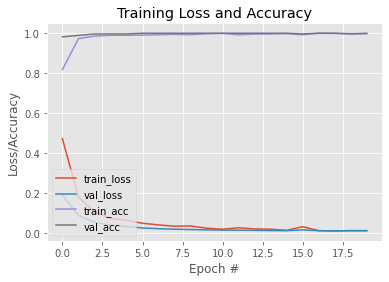

In [12]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot")

In [13]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

In [23]:
print("[INFO] loading face mask detector model...")
model = load_model("model")

[INFO] loading face mask detector model...


In [27]:
image = cv2.imread("C:\\Users\\Admin\\Desktop\\Siddharth\\Deep Learning\\Assesment\\with_mask\\21-with-mask.jpg")
orig = image.copy()
(h, w) = image.shape[:2]

In [28]:

face = image
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
face = cv2.resize(face, (224, 224))
face = img_to_array(face)
face = preprocess_input(face)
face = np.expand_dims(face, axis=0)
(mask, withoutMask) = model.predict(face)[0]

1/1 [==============================] - 0s 45ms/step


In [29]:
label = "Mask" if mask > withoutMask else "No Mask"
color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
cv2.putText(image, label, (50, 50),
cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
cv2.imshow("Output", image)
cv2.waitKey(0)

-1